In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import json
import skimage.io
import random
import tensorflow as tf

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
class OneHotEncoder(object):
    def __init__(self, tags):
        self.tags = tags
        self.dict = {}
        for i, tag in enumerate(tags):
            self.dict[tag] = i
    
    def encode(self, tags, max_batch_length=64):
        result = [0] * max_batch_length
        for tag in tags:
            if tag in self.tags:
                result[self.dict[tag]] = 1
        result = tf.convert_to_tensor(result, dtype=tf.dtypes.int64)
        return result
    
    def decode(self, encoded):
        result = []
        encoded = encoded.numpy().tolist()
        for i, true in enumerate(encoded):
            if true:
                result.append(self.tags[i])
        return result

In [13]:
base_metadata_path = "../datasets/archive/danbooru-metadata/danbooru-metadata"
base_image_path = "../datasets/archive/danbooru-images/danbooru-images"
tags = ['1boy', '1girl', '2girls', '3girls', 'ahoge', 'animal_ears', 'bangs', 'bare_shoulders', 'black_legwear', 'blush', 'boots', 'bow', 'braid', 'breasts', 'cleavage', 'closed_eyes', 'detached_sleeves', 'dress', 'flower', 'food', 'full_body', 'glasses', 'gloves', 'hat', 'heart', 'holding', 'jacket', 'japanese_clothes', 'jewelry', 'large_breasts', 'long_hair', 'long_sleeves', 'male_focus', 'medium_breasts', 'multiple_boys', 'multiple_girls', 'navel', 'necktie', 'one_eye_closed', 'open_mouth', 'panties', 'pantyhose', 'ponytail', 'ribbon', 'school_uniform', 'shirt', 'shoes', 'short_hair', 'simple_background', 'sitting', 'skirt', 'smile', 'solo', 'standing', 'swimsuit', 'sword', 'tail', 'thighhighs', 'twintails', 'underwear', 'very_long_hair', 'weapon', 'white_background', 'wings']
encoder = OneHotEncoder(tags)

In [14]:
def fix_dim(img):
    if len(img.shape) == 3:
        return img
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

In [15]:
import tensorflow.keras.preprocessing.image as kimg

def load_image(path):
    x = kimg.load_image(path)
    x = kimg.image_to_array(x)
    return resize(fix_dim(x), (256, 256))

In [16]:
import json
import time

def image_gen(batch_size=64, train=True):
    x = []
    y = []


    batcher = get_one()

    while True:
        x, y = next(batcher)
        num = random.randint(0, 19)
        if num % 20 == 0 and train: continue
        if num % 20 != 0 and (not train): continue

        x.append(x)
        y.append(y)

        if len(x) == batch_size:
            yield x, y
            x = []
            y = []


def get_one():
    for file in os.listdir(base_metadata_path):
        with open(os.path.join(base_metadata_path, file), 'r') as f:
            for i, line in enumerate(f):
                j = json.loads(line)

                # get json fields
                image_id = j['id']
                ext = j['file_ext']
                tags = j['tags']

                # get tag names and ids
                tag_names = list(map(lambda t: t['name'], tags))

                # dir of the image
                image_path = str(int(image_id) % 1000).zfill(4)

                # path to image
                path = os.path.join(base_image_path, image_path, image_id) + f'.{ext}'
                # due to the smaller subset, not all images are available (?)
                if os.path.exists(path):
                    x = load_image(path)
                    y = encoder(tag_names)
                    yield x, y

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size=32, dim=(256, 256), n_channels=3, n_classes=10, shuffle=True, train=True):
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.validation_data = not train

    def __len__(self):
        return

    def __getitem__(self, index):
        return next(image_gen(batch_size=self.batch_size, train=self.train))

In [18]:
from distutils.version import LooseVersion
from skimage import transform

def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)

def load_image(path):
    x = tf.convert_to_tensor(resize(fix_dim(skimage.io.imread(path)), (1024, 1024)), dtype = tf.dtypes.float32)
    return fix_dim(x)

In [19]:
def data(training=True):
    random.seed(39)
    for file in os.listdir(base_metadata_path):
        with open(os.path.join(base_metadata_path, file), 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                num = random.randint(0, 19)
                if num % 20 == 0 and training: continue
                if num % 20 != 0 and (not training): continue
                j = json.loads(line)
                
                # get json fields
                image_id = j['id']
                ext = j['file_ext']
                tags = j['tags']
            
                # get tag names and ids
                tag_names = list(map(lambda t: t['name'], tags))
            
                # dir of the image
                image_path = str(int(image_id) % 1000).zfill(4)
            
                # path to image
                path = os.path.join(base_image_path, image_path, image_id) + f'.{ext}'
                # due to the smaller subset, not all images are available
                if os.path.exists(path):
                    try:
                        x = load_image(path)
                    except:
                        continue
                    y = tag_names
                    y = encoder.encode(y)
                    yield x, y

In [87]:
train_dataset = tf.data.Dataset.from_generator(data,
                                                   output_signature=(
                                                       tf.TensorSpec(shape=(1024, 1024, 3)),
                                                       tf.TensorSpec(shape=[64])
                                                   )).batch(batch_size=1)
valid_dataset = tf.data.Dataset.from_generator(lambda: data(False),
                                                   output_signature=(
                                                       tf.TensorSpec(shape=(1024, 1024, 3)),
                                                       tf.TensorSpec(shape=[64])
                                                   )).batch(batch_size=1)

In [88]:
import segmentation.mrcnn_directed
import segmentation.mrcnn_directed.config
import segmentation.mrcnn_directed.model
import os
MODEL_DIR = '../segmentation/model'

class InferenceConfig(segmentation.mrcnn_directed.config.Config):
    NAME = "manga"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = segmentation.mrcnn_directed.model.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR, resnet_only=True)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
resnet = model.keras_model

Loading weights from  ../segmentation/model\manga20220213T2059\mask_rcnn_manga_0002.h5
Re-starting from epoch 2


In [89]:
resnet.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['input_image[0][0]']            
 D)                             3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9472        ['zero_padding2d_6[0][0]']       
                                64)                                                          

In [90]:
model = tf.keras.Sequential(
    [
        resnet,
        tf.keras.layers.GlobalAveragePooling2D(),
#        tf.keras.layers.BatchNormalization(1),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
   #     tf.keras.layers.BatchNormalization(1),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    #    tf.keras.layers.BatchNormalization(1),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
     #   tf.keras.layers.BatchNormalization(1),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
      #  tf.keras.layers.BatchNormalization(1),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.sigmoid),
    ]
)

In [91]:
model.layers[0].trainable = False

In [92]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet (Functional)         (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_30 (Dropout)        (None, 2048)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               262272    
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                      

In [93]:
import tensorflow_addons as tfa

In [179]:
def loss():
    alpha = 1000 / tf.constant([16.303212374015718, 88.35169215769618, 20.550116348599133, 5.83844234560697, 7.334524435607234, 11.65887407215294, 9.841002254929506, 9.405145273653346, 7.958292209086478, 30.780748329214905, 7.8988571661851825, 16.454501574128106, 8.026732561518271, 25.643519419049472, 11.136566119383989, 11.022498865331, 7.091981432252456, 18.54673515504742, 9.086957670242375, 7.1760309878704485, 6.085788180711348, 7.312911692734036, 16.653218737767787, 24.621116610353464, 5.768801285237776, 7.008532230603164, 5.737582878865378, 7.2000451466184465, 10.636471263456935, 12.402712639372172, 58.73983300554006, 11.150374260664087, 7.831617521690789, 9.638082613508924, 7.251075233957941, 33.75730330602923, 8.616280158781617, 6.376959855530822, 6.413581447621517, 27.237459205947825, 6.105599861678446, 7.662317702517405, 9.543226686454332, 18.305392859630036, 16.40527254869471, 10.070337470972886, 5.625316686718489, 38.29898107924432, 14.20857737722161, 12.1031360089909, 24.429603694338184, 38.44306603173231, 77.0818474572608, 6.513240206425709, 7.26608408317544, 6.224469947481034, 7.675525489828804, 18.7004257710346, 15.346848501876707, 7.660516640611305, 9.853609688272206, 12.33187087106558, 11.346089654460268, 8.25246565374945], dtype = tf.dtypes.float32)
    def loss_fn(y_true, y_pred):
        weights = alpha * y_true + 1 - y_true
        a=y_true * y_pred
        b=(1 - y_true) * (1 - y_pred)
        no_weight_loss = - tf.math.log(a + b)
        return weights * no_weight_loss
    return loss_fn
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tfa.optimizers.AdaBelief(learning_rate=0.01, epsilon=1e-7))

In [180]:
alpha_ = sorted(list(enumerate([16.303212374015718, 88.35169215769618, 20.550116348599133, 5.83844234560697, 7.334524435607234, 11.65887407215294, 9.841002254929506, 9.405145273653346, 7.958292209086478, 30.780748329214905, 7.8988571661851825, 16.454501574128106, 8.026732561518271, 25.643519419049472, 11.136566119383989, 11.022498865331, 7.091981432252456, 18.54673515504742, 9.086957670242375, 7.1760309878704485, 6.085788180711348, 7.312911692734036, 16.653218737767787, 24.621116610353464, 5.768801285237776, 7.008532230603164, 5.737582878865378, 7.2000451466184465, 10.636471263456935, 12.402712639372172, 58.73983300554006, 11.150374260664087, 7.831617521690789, 9.638082613508924, 7.251075233957941, 33.75730330602923, 8.616280158781617, 6.376959855530822, 6.413581447621517, 27.237459205947825, 6.105599861678446, 7.662317702517405, 9.543226686454332, 18.305392859630036, 16.40527254869471, 10.070337470972886, 5.625316686718489, 38.29898107924432, 14.20857737722161, 12.1031360089909, 24.429603694338184, 38.44306603173231, 77.0818474572608, 6.513240206425709, 7.26608408317544, 6.224469947481034, 7.675525489828804, 18.7004257710346, 15.346848501876707, 7.660516640611305, 9.853609688272206, 12.33187087106558, 11.346089654460268, 8.25246565374945])), key = lambda x:x[1])
alpha__ = [0] * 64
for i in range(64):
    alpha__[alpha_[-1-i][0]] = alpha_[i][1]
alpha = alpha__[:]

In [181]:
print(alpha)

[7.660516640611305, 5.625316686718489, 7.091981432252456, 38.44306603173231, 16.40527254869471, 8.026732561518271, 9.853609688272206, 11.022498865331, 12.1031360089909, 6.224469947481034, 12.33187087106558, 7.312911692734036, 11.65887407215294, 6.413581447621517, 9.086957670242375, 9.405145273653346, 20.550116348599133, 7.2000451466184465, 11.136566119383989, 18.7004257710346, 38.29898107924432, 16.454501574128106, 7.26608408317544, 6.513240206425709, 58.73983300554006, 24.429603694338184, 77.0818474572608, 18.54673515504742, 9.543226686454332, 7.831617521690789, 5.768801285237776, 8.616280158781617, 12.402712639372172, 10.070337470972886, 18.305392859630036, 6.105599861678446, 11.150374260664087, 27.237459205947825, 25.643519419049472, 6.376959855530822, 33.75730330602923, 15.346848501876707, 10.636471263456935, 7.251075233957941, 7.334524435607234, 9.638082613508924, 88.35169215769618, 6.085788180711348, 7.675525489828804, 7.958292209086478, 7.008532230603164, 5.83844234560697, 5.737

In [182]:
hist = model.fit(x=train_dataset, validation_data=valid_dataset, epochs=1)

   4653/Unknown - 1187s 254ms/step - loss: 0.3657

KeyboardInterrupt: 

In [50]:
model.save('dying')

INFO:tensorflow:Assets written to: dying\assets


In [21]:
from adabelief_tf import AdaBeliefOptimizer
model = tf.keras.models.load_model("final", custom_objects={"AdaBeliefOptimizer": AdaBeliefOptimizer})

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [12]:
model.load_weights('model')

In [183]:
wee = valid_dataset.take(5)

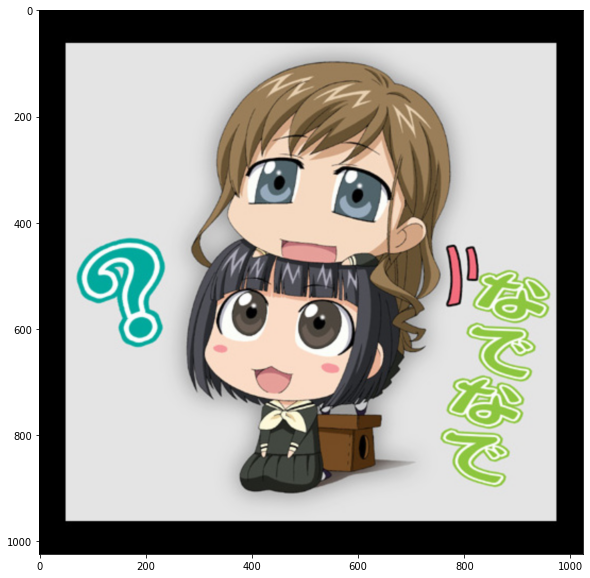

In [194]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(list(wee)[3][0][0])

In [195]:
encoder.decode((model(tf.expand_dims(list(wee)[0][0][0], axis=0)) > 0.3)[0])

['1girl', 'long_hair', 'solo']

In [187]:
(model(tf.expand_dims(wee, axis=0)))

ValueError: Attempt to convert a value (<TakeDataset element_spec=(TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64), dtype=tf.float32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>) to a Tensor.